## RNNLM
- RNN Language Model

In [3]:
#SimpleRnnlm 구현

import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self,vocab_size,wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V,D) / 100).astype('f')
        rnn_Wx = (rn(D,H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H,H)) / np.sqrt(H).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H,V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True), #stateful- 상태가 계승된다
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self): # 신경망 초기화
        self.rnn_layer.reset_state()


말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 378.09
| 에폭 2 | 퍼플렉서티 246.13
| 에폭 3 | 퍼플렉서티 219.80
| 에폭 4 | 퍼플렉서티 213.65
| 에폭 5 | 퍼플렉서티 204.79
| 에폭 6 | 퍼플렉서티 201.97
| 에폭 7 | 퍼플렉서티 197.40
| 에폭 8 | 퍼플렉서티 196.14
| 에폭 9 | 퍼플렉서티 191.80
| 에폭 10 | 퍼플렉서티 192.85
| 에폭 11 | 퍼플렉서티 188.54
| 에폭 12 | 퍼플렉서티 192.68
| 에폭 13 | 퍼플렉서티 190.14
| 에폭 14 | 퍼플렉서티 190.82
| 에폭 15 | 퍼플렉서티 189.90
| 에폭 16 | 퍼플렉서티 187.18
| 에폭 17 | 퍼플렉서티 184.87
| 에폭 18 | 퍼플렉서티 182.05
| 에폭 19 | 퍼플렉서티 182.57
| 에폭 20 | 퍼플렉서티 183.69
| 에폭 21 | 퍼플렉서티 182.27
| 에폭 22 | 퍼플렉서티 178.89
| 에폭 23 | 퍼플렉서티 175.74
| 에폭 24 | 퍼플렉서티 176.77
| 에폭 25 | 퍼플렉서티 176.32
| 에폭 26 | 퍼플렉서티 175.28
| 에폭 27 | 퍼플렉서티 170.87
| 에폭 28 | 퍼플렉서티 168.73
| 에폭 29 | 퍼플렉서티 168.42
| 에폭 30 | 퍼플렉서티 161.17
| 에폭 31 | 퍼플렉서티 165.14
| 에폭 32 | 퍼플렉서티 159.15
| 에폭 33 | 퍼플렉서티 161.56
| 에폭 34 | 퍼플렉서티 153.84
| 에폭 35 | 퍼플렉서티 154.35
| 에폭 36 | 퍼플렉서티 149.02
| 에폭 37 | 퍼플렉서티 146.30
| 에폭 38 | 퍼플렉서티 141.21
| 에폭 39 | 퍼플렉서티 134.37
| 에폭 40 | 퍼플렉서티 132.90
| 에폭 41 | 퍼플렉서티 131.41
| 에폭 42 | 퍼플렉서티 125.10
| 에폭 43 | 퍼플렉서티 119

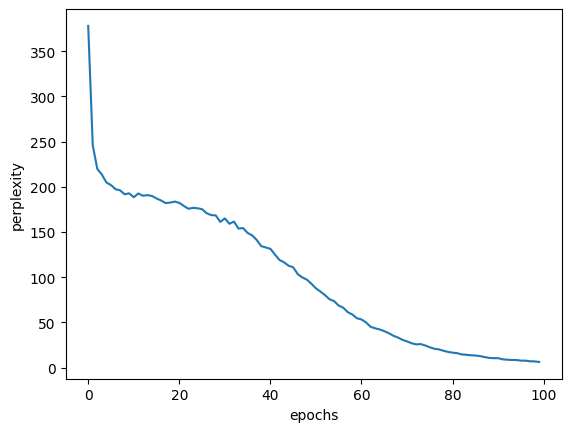

In [5]:
# 학습 코드

import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm

# 하이퍼파라미터 설정

batch_size = 10
wordvec_size = 100
hidden_size = 100 #RNN의 은닉 상태 벡터의 원소 수
time_size = 5 # Truncated BPTT가 한 번에 펼쳐지는 시간 크기(한 블록(한 번에 처리하는 시간 단계)의 크기)
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

xs = corpus[:-1] #입력
ts = corpus[1:] #출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 각 미니배치에서 샘플을 읽기 시작하는 위치(offset)를 계산
jump = (corpus_size - 1) // batch_size # 말뭉치의 크기에서 1을 빼주면, 미니배치를 구성할 수 있는 데이터의 최대 범위를 설정 가능
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 획득
        batch_x = np.empty((batch_size, time_size), dtype='i') #zeros는 메모리를 할당받아 0으로 초기화한 뒤에 반환, empty는 메모리 할당만 받고 초기화 없이 반환
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        
        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티(혼란도=낮을수록 성능 좋음) 평가
    ppl = np.exp(total_loss/loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list)) #len(ppl_list) 값만큼 배열 변환(0부터 시작)
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()
